In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator
import streamlit as st
import mlflow
import dvc.api
from google.cloud import storage

import cv2
import matplotlib.pyplot as plt
import random
import numpy as np

from ultralytics import YOLO
from PIL import Image
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms


2024-05-06 15:19:54.372938: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
global storage_client
global bucket_name
storage_client = storage.Client()
bucket_name = "mlops-car-detection"

def list_blobs(bucket_name):
    # Note: Client.list_blobs requires at least package version 1.17.0.
    blobs = storage_client.list_blobs(bucket_name)
    
    # for blob in blobs:
    #     print(blob.name)
        
    blob_names = [blob.name for blob in blobs if blob.name.endswith('.jpg')]
    return blob_names
    # blob_list_names = [blob.name for blob in blobs if blob.name.endswith(".jpg")]

In [3]:
def display_random_image(bucket_name):
    blob_names = list_blobs(bucket_name)
    if not blob_names:
        print("No .jpg files found in the bucket.")
        return
    
    # Randomly select a blob name
    selected_blob_name = random.choice(blob_names)
    # print("Selected Blob:", selected_blob_name)

    # Download the selected blob
    blob = storage_client.bucket(bucket_name).get_blob(selected_blob_name)
    if blob is None:
        print("Failed to retrieve blob.")
        return

    # Download the blob's content
    blob_content = blob.download_as_bytes()

    # Decode the image content
    nparr = np.frombuffer(blob_content, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Display the image
    # cv2.imshow("Random Image", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    return image

# Call the function to display a random image from the specified bucket
display_random_image(bucket_name)

array([[[ 73,  84,  92],
        [ 51,  66,  75],
        [ 70,  86, 102],
        ...,
        [189, 175, 157],
        [189, 175, 157],
        [189, 175, 157]],

       [[ 73,  84,  92],
        [ 57,  69,  79],
        [ 74,  91, 104],
        ...,
        [189, 175, 157],
        [189, 175, 157],
        [189, 175, 157]],

       [[ 79,  89,  96],
        [ 67,  80,  88],
        [ 86, 102, 114],
        ...,
        [189, 175, 157],
        [189, 175, 157],
        [189, 175, 157]],

       ...,

       [[100,  89,  85],
        [103,  92,  88],
        [107,  96,  92],
        ...,
        [103,  94,  80],
        [102,  93,  79],
        [100,  91,  77]],

       [[104,  92,  90],
        [101,  89,  87],
        [ 98,  86,  84],
        ...,
        [106,  97,  83],
        [105,  96,  82],
        [104,  95,  81]],

       [[ 98,  86,  84],
        [ 99,  87,  85],
        [ 99,  87,  85],
        ...,
        [102,  93,  79],
        [103,  94,  80],
        [103,  94,  80]]

In [4]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, maskrcnn_resnet50_fpn

# Initialize Faster R-CNN
faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)

/Users/dragxn/anaconda3/envs/environML/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dragxn/anaconda3/envs/environML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


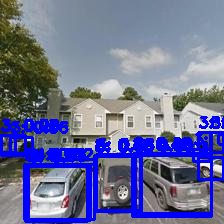

In [5]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as transforms


# Assuming display_random_image() retrieves an image
image = display_random_image(bucket_name)

# Preprocess the image
transform = transforms.Compose([transforms.ToTensor()])
input_image = transform(image).unsqueeze(0)  # Add a batch dimension

# Set the model to evaluation mode
faster_rcnn_model.eval()

# Forward pass
with torch.no_grad():
    prediction = faster_rcnn_model(input_image)

# Convert the image to a numpy array
plot = np.array(image)

# Post-process the output to get bounding boxes, labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Draw bounding boxes on the image
for box, label, score in zip(boxes, labels, scores):
    box = box.astype(int)
    color = (255, 0, 0)  # Red color
    cv2.rectangle(plot, (box[0], box[1]), (box[2], box[3]), color, 2)
    cv2.putText(plot, f"{label}: {score:.2f}", (box[0], box[1] - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Convert image from BGR to RGB
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

# Display the image
display(Image.fromarray(plot))


/Users/dragxn/anaconda3/envs/environML/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dragxn/anaconda3/envs/environML/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


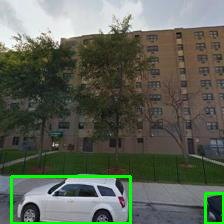

In [49]:
import torch
import numpy as np
import cv2
from PIL import Image
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.transforms import functional as F

# Load the pre-trained Faster R-CNN model
mask_rcnn_model = maskrcnn_resnet50_fpn(pretrained=True)

# Assuming display_random_image() retrieves an image
image = display_random_image(bucket_name)

# Preprocess the image
input_image = F.to_tensor(image).unsqueeze(0)  # Add a batch dimension

# Set the model to evaluation mode
mask_rcnn_model.eval()

# Forward pass
with torch.no_grad():
    prediction = mask_rcnn_model(input_image)

# Convert the image to a numpy array
plot = np.array(image)

# Post-process the output to get bounding boxes, labels, and scores
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Draw bounding boxes on the image for cars only
for box, label in zip(boxes, labels):
    if label == 3:  # Assuming '3' is the label index for 'car' class
        box = box.astype(int)
        color = (0, 255, 0)  # Green color for car bounding boxes
        cv2.rectangle(plot, (box[0], box[1]), (box[2], box[3]), color, 2)

# Convert image from BGR to RGB
plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

# Display the image
display(Image.fromarray(plot))
